# Alineamientos

Funcion para crear el dotplot.
(DUDA: EN EL GRAFICO DE LA CLASE SE VEÍA DIFERENTE CON UN EJEMPLO... CONSULTAR)

In [140]:
import numpy as np
from Bio import SeqIO
import matplotlib.pyplot as plt
from Bio.Align import substitution_matrices

In [141]:
def read_fasta(filename):
    with open(filename,'r') as handle:
        r_seq = list(SeqIO.parse(handle, 'fasta'))
        return r_seq[0].seq, r_seq[1].seq

In [401]:
class Alignment: 
    def __init__(self, seq1, seq2, k, type_of_sequences, threshold=0):
        """
        Genera la mejor alineación entre dos secuencias utilizando un dotplot filtrado.
        
        Args:
            seq1 (str): Primera secuencia a alinear.
            seq2 (str): Segunda secuencia a alinear.
            k (int): Tamaño de las submatrices cuadradas utilizadas en el filtrado del dotplot.
            t (str): Tipo de secuencia ('PROTEIN' o 'DNA').
        
        Returns:
            tuple: Una tupla que contiene la alineación traducida, el dotplot original, y el dotplot filtrado.
        
        Raises:
            ValueError: Si el tamaño `k` es mayor que las dimensiones de la matriz `dotplot`.
        """        
        if len(seq1) <= len(seq2):
            self.seq1 = seq1
            self.seq2 = seq2
        else:
            self.seq1 = seq2
            self.seq2 = seq1
        self.type_of_sequences = type_of_sequences.upper()
        if self.type_of_sequences == 'ADN':
            self.threshold = (k/2)
        elif threshold==0:
            self.threshold = self.__obtain_threshold()          
        if k > len(seq1) or k > len(seq2):
            raise ValueError(f"El tamaño 'k' ({k}) es mayor que las dimensiones de la matriz dotplot.")
        self.k = k

        self.dotplot = self.__make_dotplot(self.seq1, self.seq2)
        self.f_dotplot = self.__filtered_dotplot(k)
        self.best_alignment = self.__obtain_best_alignment()
        self.traduced_alignment = self.__traduce_alignment()
        self.score = self.__get_score()

    def __get_score(self):
        score = 0.0
        for coord in self.best_alignment:
            score += self.dotplot[coord[0]][coord[1]]
        return score
    
    def __obtain_threshold(self):
        t_dotplot1, t_dotplot2 = self.__make_dotplot(self.seq1, self.seq1), self.__make_dotplot(self.seq2, self.seq2)
        i=0
        j=0
        threshold1, threshold2 = 0, 0
    
        while i < len(t_dotplot1) and j < len(t_dotplot1[0]):
            threshold1 += t_dotplot1[i, j]
            i+=1
            j+=1
        i=0
        j=0
        while i < len(t_dotplot2) and j < len(t_dotplot2[0]):
            threshold2 += t_dotplot2[i, j]
            i+=1
            j+=1
        threshold = ((threshold1/len(self.seq1)) + (threshold2/len(self.seq2))/2)
    
        return threshold

    def __traduce_alignment(self):
        traduced_seq = ''
        for i in range(len(self.best_alignment)):
            if self.seq1[self.best_alignment[i][0]] == self.seq2[self.best_alignment[i][1]]:
                traduced_seq += f"{self.seq1[self.best_alignment[i][0]]}{i}"
            else:
                # traduced_seq += f"{seq1[alignment_list[i-1][0]]}"
                # Si se prefiere un guion en vez de repetir la ultima base:
                traduced_seq += "-"
        return traduced_seq

    def __obtain_best_alignment(self):
        complete = False
        alignment_list = []
        i = 0
        j = 0
    
        while not complete:
            # Verificar si hemos llegado al final de alguna secuencia
            if i >= len(self.f_dotplot) or j >= len(self.f_dotplot[0]):
                complete = True
            else:
                alignment_list.append([i, j])  # Agregar la posición actual al alineamiento
    
                # Verificar si podemos movernos en diagonal
                if i + 1 < len(self.f_dotplot) and j + 1 < len(self.f_dotplot[0]) and self.f_dotplot[i + 1, j + 1] == 1:
                    i += 1
                    j += 1
                # Verificar si podemos movernos horizontalmente (gap en seq1)
                elif j + 1 < len(self.f_dotplot[0]) and self.f_dotplot[i, j + 1] == 1:
                    j += 1
                # Verificar si podemos movernos verticalmente (gap en seq2)
                elif i + 1 < len(self.f_dotplot) and self.f_dotplot[i + 1, j] == 1:
                    i += 1
                else:
                    if i<len(self.f_dotplot) and j<len(self.f_dotplot[0]):
                        j+=1
                    else:
                        complete = True
    
        return alignment_list



    def __has_potential(self, subdotplot):
        score = 0
        for i in range(len(subdotplot)):
            score += subdotplot[i,i]
    
        if score > self.threshold:
            return True
        return False
    
    def __filtered_dotplot(self,k):
        """
        Filtra una matriz de dotplot resaltando las regiones diagonales de tamaño k con mayor puntuación.
        
        La función evalúa las submatrices de tamaño `k x k` dentro de la matriz `dotplot`, buscando aquellas que tienen un número mayoritario de unos en su diagonal principal. Si la submatriz cumple con el criterio, se añade al dotplot filtrado.
        
        Returns:
            numpy.ndarray: Una nueva matriz del mismo tamaño que `dotplot`, donde las regiones que cumplen con 
            el criterio están resaltadas con unos en la diagonal.
        
        """
        rows, cols = len(self.dotplot), len(self.dotplot[0])
        f_dotplot = np.zeros((rows, cols))
    
        for i in range(rows-k+1):
            for j in range(cols-k+1):
                sub_dotplot = self.dotplot[i:i+k, j:j+k]
                if self.__has_potential(sub_dotplot):
                    if self.type_of_sequences == 'ADN':
                        f_dotplot[i:i+k, j:j+k] = sub_dotplot * np.eye(k)
                    elif self.type_of_sequences == 'PROTEIN':
                        f_dotplot[i,j]=1
    
        return f_dotplot

    def show_dotplot(self, filtered=False, show_values=False, show_alignment=False):
        
        if filtered:
            dtplt = self.f_dotplot
        else:
            dtplt = self.dotplot
            
        plt.imshow(dtplt, cmap="gray_r", interpolation='nearest')
        if not filtered:
            k_message = "SIN FILTRAR"     
        else:
            k_message = f"k={k}"
    
        if show_values:
            for i in range(len(dtplt)):
                for j in range(len(dtplt[0])):
                    value = dtplt[i][j]
                    plt.text(j, i, f'{value:.1f}', ha='center', va='center', color='red', fontsize=8)

        num_rows = len(dtplt)
        num_cols = len(dtplt[0])
        if num_rows > num_cols:
            point_size = num_rows/num_cols
        else: 
            point_size = num_cols/num_rows
        # Mostrar el alineamiento en rojo (opcional)
        if show_alignment and hasattr(self, 'best_alignment'):
            for alg in self.best_alignment:
                # Limitar los puntos a las dimensiones del dotplot
                if 0 <= alg[0] < num_rows and 0 <= alg[1] < num_cols:
                    plt.scatter(alg[1], alg[0], color='red', s=point_size)  # Trazar los puntos del alineamiento
                
        plt.title(f'Dotplot: {len(dtplt)} elementos vs {len(dtplt[0])} elementos | {k_message}')
        plt.xlabel("Secuencia 2")
        plt.ylabel("Secuencia 1")
        plt.show()
    
    def __prepare_seq_to_show_alignment(self, seq, position, len_of_seq2, len_score):
        prepared_seq = ""
        i=0
        while i < len_of_seq2:
            if i == position:
                j=0
                while j < len_score:
                    prepared_seq += seq[j]
                    j+=1
                i=i+j
            else:
                prepared_seq += "-"
            i+=1
        return prepared_seq
                
    def show_alignments(self):
        match_line = ''
        match_score = 0
        best_score = 0
        position = 0
        
        for i in range(len(self.best_alignment)):
            base_seq1 = self.seq1[self.best_alignment[i][0]]
            base_seq2 = self.seq2[self.best_alignment[i][1]]
    
            # Verificar si son iguales
            if base_seq1 == base_seq2:
                match_line += '|'
                match_score += 1
            else:
                match_line += '.'
                if match_score > best_score:
                    best_score = match_score
                    position = i-best_score
                match_score = 0

        print(self.__prepare_seq_to_show_alignment(self.seq1, position, len(self.seq2), best_score))
        print(match_line)
        print(self.seq2)
    
    def __make_dotplot(self, s1, s2):
        dotplot = np.zeros((len(s1),len(s2)))
    
        for i in range(len(s1)):
            for j in range(len(s2)):
                if self.type_of_sequences=='ADN':
                    if s1[i]==s2[j]:
                        dotplot[i,j] = 1
                else:
                    dotplot[i,j] = substitution_matrices.load('BLOSUM62')[s1[i],s2[j]]
    
        return dotplot


In [402]:
file = "./documents/TP53.fna"
seq1, seq2 = read_fasta(file)
seq1, seq2 = seq1[:1000], seq2[:1000]

# Ventana de filtrado de alineamientos:
k = 30

alignment = Alignment(seq1, seq2, k, "adn")

# seq1 = 'TACG'
# seq2 = 'TATCG'
# k = 3
# threshold = (k/2)
# align, dotplot, f_dotplot = alignment(seq1, seq2, k, "ADN", threshold)

# RESULTADOS

#### Dotplot sin filtrar

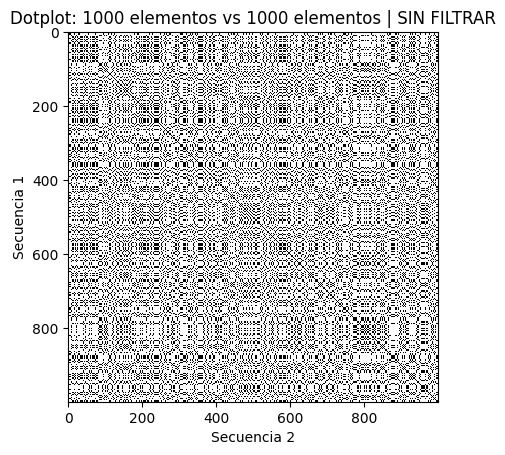

In [403]:
alignment.show_dotplot()

#### Dotplot filtrado

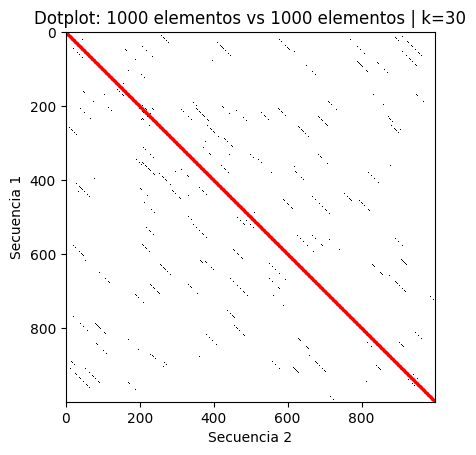

In [404]:
alignment.show_dotplot(filtered=True, show_alignment=True)

#### Mejor alineamiento

In [405]:
alignment.traduced_alignment

'C0T1C2A3A4A5A6G7T8C9T10A11G12A13G14C15C16A17C18C19G20T21C22C23A24G25G26G27A28G29C30A31G32G33T34A35G36C37T38G39C40T41G42G43G44C45T46C47C48G49G50G51G52A53C54A55C56T57T58T59G60C61G62T63T64C65G66G67G68C69T70G71G72G73A74G75C76G77T78G79C80T81T82T83C84C85A86C87G88A89C90G91G92T93G94A95C96A97C98G99C100T101T102C103C104C105T106G107G108A109T110T111G112G113G114T115A116A117G118C119T120C121C122T123G124A125C126T127G128A129A130C131T132T133G134A135T136G137A138G139T140C141C142T143C144T145C146T147G148A149G150T151C152A153C154G155G156G157C158T159C160T161C162G163G164C165T166C167C168G169T170G171T172A173T174T175T176T177C178A179G180C181T182C183G184G185G186A187A188A189A190T191C192G193C194T195G196G197G198G199C200T201G202G203G204G205G206T207G208G209G210G211C212A213G214T215G216G217G218G219A220C221T222T223A224G225C226G227A228G229T230T231T232G233G234G235G236G237T238G239A240G241T242G243G244G245A246T247G248G249A250A251G252C253T254T255G256G257C258T259A260G261A262G263G264G265A266T267C268A269T270C271A272T273A274G275G276A

### Comparación con Biopython

Función de alineamiento de biopython

In [216]:
from Bio import pairwise2

# Realizar el alineamiento
al = pairwise2.align.globalxx(seq1, seq2)

# Imprimir los alineamientos
for a in al:
    print(pairwise2.format_alignment(*a))

CTCAAAAGTCTAGAGCCACCGTCCAGGGAGCAGGTAGCTGCTGGGCTCCGGGGACACTTTGCGTTCGGGCTGGGAGCGTGCTTTCCACGACGGTGACACGCTTCCCTGGATTGGGTAAGCTCCTGACTGAACTTGATGAGTCCTCTCTGAGTCACGGGCTCTCGGCTCCGTGTATTTTCAGCTCGGGAAAATCGCTGGGGCTGGGGGTGGGGCAGTGGGGACTTAGCGAGTTTGGGGGTGAGTGGGATGGAAGCTTGGCTAGAGGGATCATCATAGGAGTTGCATTGTTGGGAGACCTGGGTGTAGATGATGGGGATGTTAGGACCATCCGAACTCAAAGTTGAACGCCTAGGCAGAGGAGTGGAGCTTTGGGGAACCTTGAGCCGGCCTAAAGCGTACTTCTTTGCACATCCACCCGGTGCTGGGCGTAGGGAATCCCTGAAATAAAAGATGCACAAAGCATTGAGGTCTGAGACTTTTGGATCTCGAAACATTGAGAACTCATAGCTGTATATTTTAGAGCCCATGGCATCCTAGTGAAAACTGGGGCTCCATTCCGAAATGATCATTTGGGGGTGATCCGGGGAGCCCAAGCTGCTAAGGTCCCACAACTTCCGGACCTTTGTCCTTCCTGGAGCGATCTTTCCAGGCAGCCCCCGGCTCCGCTAGATGGAGAAAATCCAATTGAAGGCTGTCAGTCGTGGAAGTGAGAAGTGCTAAACCAGGGGTTTGCCCGCCAGGCCGAGGAGGACCGTCGCAATCTGAGAGGCCCGGCAGCCCTGTTATTGTTTGGCTCCACATTTACATTTCTGCCTCTTGCAGCAGCATTTCCGGTTTCTTTTTGCCGGAGCAGCTCACTATTCACCCGATGAGAGGGGAGGAGAGAGAGAGAAAATGTCCTTTAGGCCGGTTCCTCTTACTTGGCAGAGGGAGGCTGCTATTCTCCGCCTGCATTTCTTTTTCTGGATTACTTAGTTATGGCCTTTGCAAAGGCAGGGGT

# ALINEAMIENTO DE PROTEINAS

Utilizamos la misma funcion pero enviando 'PROTEIN' en el parametro t (tipo).

Y cargamos una proteina existente, tomando como primer secuencia los primeros 100 aminoacidos y en la segunda secuencia los primeros 150... para corroborar que haya match en los primeros 100.

In [406]:
prot = SeqIO.read("./documents/my_prot.txt","swiss")
prot_seq2 = prot.seq[20:40]
prot_seq1 = prot.seq[:60]
prot_k=3

# Threshold es opcional. Si no se le envia nada en ese parametro, la funcion calculara el umbral en base a la media del score de la diagonal principal de la primer secuencia
alignment_protein = Alignment(prot_seq1, prot_seq2, prot_k, "PROTEIN")

Grafico Sin filtrar

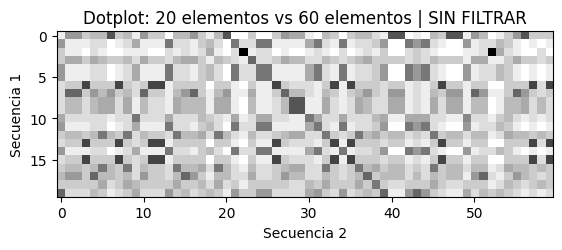

In [407]:
alignment_protein.show_dotplot()

Grafico filtrado

In [408]:
alignment_protein.type_of_sequences

'PROTEIN'

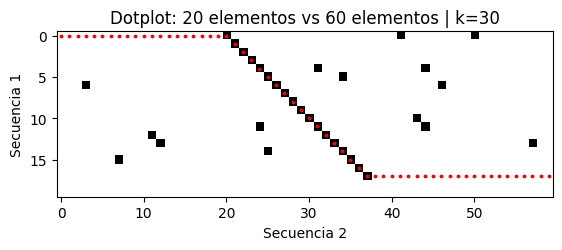

In [409]:
alignment_protein.show_dotplot(filtered=True, show_alignment=True)

Mejor alineamiento

In [410]:
alignment_protein.traduced_alignment

'------D6-------------D20L21W22K23L24L25P26E27N28N29V30L31S32P33L34P35S36Q37-------------Q51--------'

In [411]:
alignment_protein.show_alignments()

--------------------DLWKLLPENNVLSPLPSQ---------------------
......|.............||||||||||||||||||.............|........
MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLSPDDIEQWFTEDPGP


# ALINEAMIENTO MULTIPLE

Obtenemos secuencias de proteinas con una funcion simple

In [412]:
def obtain_protein_sequence(prot,k):
    sequences = []
    i = 0
    num_of_seq = 1
    while i<=(len(prot)-k):
        sequences.append([prot.seq[i:i+k], f"seq{num_of_seq}"])
        num_of_seq += 1
        i+=k
    return sequences

In [413]:
sequences = obtain_protein_sequence(prot,30)

print(sequences)

[[Seq('MEEPQSDPSVEPPLSQETFSDLWKLLPENN'), 'seq1'], [Seq('VLSPLPSQAMDDLMLSPDDIEQWFTEDPGP'), 'seq2'], [Seq('DEAPRMPEAAPPVAPAPAAPTPAAPAPAPS'), 'seq3'], [Seq('WPLSSSVPSQKTYQGSYGFRLGFLHSGTAK'), 'seq4'], [Seq('SVTCTYSPALNKMFCQLAKTCPVQLWVDST'), 'seq5'], [Seq('PPPGTRVRAMAIYKQSQHMTEVVRRCPHHE'), 'seq6'], [Seq('RCSDSDGLAPPQHLIRVEGNLRVEYLDDRN'), 'seq7'], [Seq('TFRHSVVVPYEPPEVGSDCTTIHYNYMCNS'), 'seq8'], [Seq('SCMGGMNRRPILTIITLEDSSGNLLGRNSF'), 'seq9'], [Seq('EVRVCACPGRDRRTEEENLRKKGEPHHELP'), 'seq10'], [Seq('PGSTKRALPNNTSSSPQPKKKPLDGEYFTL'), 'seq11'], [Seq('QIRGRERFEMFRELNEALELKDAQAGKEPG'), 'seq12'], [Seq('GSRAHSSHLKSKKGQSTSRHKKLMFKTEGP'), 'seq13']]


In [414]:
class AlignmentNode:

    def __init__(self, seq1, seq2):
        self.seq1 = seq1
        self.seq2 = seq2

    def __obtain_list_seqs(self, seq):
        if isinstance(seq, str):
            l = []
            i = 0
            while i < len(seq):
                if seq[i:i+3] == 'seq':  # Encuentra 'seq'
                    j = i + 3
                    # Encuentra el número después de 'seq'
                    while j < len(seq) and seq[j].isdigit():
                        j += 1
                    l.append(seq[i:j])  # Captura 'seq' seguido del número
                    i = j 
                else:
                    i += 1  # Avanza si no es 'seq'
            return l
        elif isinstance(seq, AlignmentNode):
            return seq.__obtain_list_seqs(seq.seq1)+(seq.__obtain_list_seqs(seq.seq2))

    def contains_seq(self, seq):
        list = self.__obtain_list_seqs(self)
        list2 = self.__obtain_list_seqs(seq)
        for seq1 in list: 
            for seq2 in list2:
                if seq1 == seq2:
                    return True
        return False
            
    
    def __str__(self):
        return f"({self.seq1}, {self.seq2})"



### Como calcular la matriz de distancia para el alineamiento multiple

1. **Buscar el par con menor distancia**

2. **Formar un nodo con esos elementos**

3. **Recalcula la matriz**: $$d(e1e2-j) = \frac{d(e1-j) + d(e2-j)}{2}$$

4. **Repetir el proceso**


In [415]:
from Bio import Phylo
from io import StringIO
import pandas as pd

class MultipleAlignment:   
    def __init__(self, sequences, type_of_sequences="ADN"):
        self.list_of_nodes = []
        self.alignments = ""
        self.matrix_history = []
        
        type_of_sequences = type_of_sequences.upper()
        if type_of_sequences == "ADN" or type_of_sequences == "PROTEIN":     
                self.type_of_sequences = type_of_sequences
        else:
            raise ValueError("type_of_sequences must be either ADN or PROTEIN")
        if self.__check_sequences(sequences):        
            self.matrix = self.__obtain_matrix(sequences)
        else:
            raise ValueError("sequence format must be like [[sequence],'name of sequence']")

    def __check_sequences(self, sequences):
        # Verificar que la lista contenga tuplas o listas con dos elementos
        if not isinstance(sequences, list):
            return False
    
        for item in sequences:
            if not isinstance(item, (tuple, list)) or len(item) != 2:
                return False
    
            sequence, name = item
            
            if self.type_of_sequences == "ADN":
                # Verificar que la secuencia sea una cadena que solo contenga A, T, C, G
                if not isinstance(sequence, str) or not all(base in 'ATCG' for base in sequence.upper()):
                    raise ValueError(f"The sequence type is: '{self.type_of_sequences}' but does not contain 'ATCG'")
                
            # Verificar que el nombre sea una cadena
            if not isinstance(name, str):
                raise ValueError(f"The name of the sequence must be a String")
    
        return True

        
    # Dibuja el dendograma
    def draw_tree(self):  
        tree = Phylo.read(StringIO(f"{self.alignments}"), "newick")
        tree.ladderize()
        Phylo.draw(tree)
    
    # Encuentra las secuencias con score mas cercano
    def __closest_neighbor(self,matrix):
        pair = []
        best_distance = -np.inf
        for i in range(len(matrix.index)):
            for j in range(i+1,len(matrix.columns)):
                distance = matrix.loc[matrix.index[i], matrix.columns[j]]
                if distance > best_distance:
                    pair=[matrix.index[i], matrix.columns[j]]
                    best_distance = matrix.loc[matrix.index[i], matrix.columns[j]]
        return pair[0], pair[1]
    
    # Revisa si existe el nodo, de ser asi lo devuelve
    def __check_if_exists_node(self, seq):
        r = None
        for node in self.list_of_nodes:
            if node.contains_seq(seq):
                r = node
            
        if r is None:
            return seq
        else:
            self.list_of_nodes.remove(r)
            return r
    
    # Se edita la matriz eliminando las columnas y las filas de los nodos conectados, y creando una nueva con el nodo nuevo.
    def __edit_matrix(self,matrix, row, column):
        seq1 = row
        seq2 = column
        
        df_copy = matrix.copy()
        matrix = matrix.drop(index=seq1, columns=seq2)
        matrix = matrix.drop(index=seq2, columns=seq1)
        
        align_node = AlignmentNode(self.__check_if_exists_node(seq1), self.__check_if_exists_node(seq2))
        self.list_of_nodes.append(align_node)
        # Insertar una columna llena de ceros en la posición dinámica
        
        matrix.insert(0, f'{align_node}', [0] * len(matrix))
        
        # Crear una fila llena de ceros para insertar con un nombre específico
        new_row = pd.DataFrame([[0] * len(matrix.columns)], columns=matrix.columns, index=[f'{align_node}'])
        
        # Insertar la fila en la posición dinámica
        matrix = pd.concat([new_row, matrix.iloc[0:]])

        matrix = matrix.astype(float)
        
        node1_str = str(align_node.seq1) 
        node2_str = str(align_node.seq2)
        
        # Reasigna valores a la matriz (en las filas y columnas nuevas hace la formula mencionada en el markdown de arriba)
        for i in range(len(matrix.index)):
            for j in range(i+1,len(matrix.columns)): 
                if matrix.index[i] == f"{align_node}": 
                    matrix.loc[matrix.index[i],matrix.columns[j]] = (df_copy.loc[node1_str,matrix.columns[j]]  + df_copy.loc[matrix.columns[j],node2_str])/2
                elif matrix.columns[j] == f"{align_node}":
                    matrix.loc[matrix.index[i],matrix.columns[j]] = (df_copy.loc[node1_str,matrix.index[i]]  + df_copy.loc[matrix.index[i],node2_str])/2
                else:
                    matrix.loc[matrix.index[i],matrix.columns[j]] = df_copy.loc[matrix.index[i],matrix.columns[j]]        
        return matrix, align_node
    
    # Alinea las secuencias
    def __align_seq(self, seq1, seq2):
        align = pairwise2.align.globalxx(seq1, seq2)
        return align[0].score
    
    # Obtiene la matriz de distancia
    def __d_matrix(self, seqs):
        n = len(seqs)
        matrix = np.zeros((n, n))
        only_seqs = [x[0] for x in seqs]
        for i in range(n):
            for j in range(i+1, n):
                new_align = Alignment(only_seqs[i], only_seqs[j], 3, self.type_of_sequences)
                matrix[i, j] = new_align.score
        df_distance_matrix = pd.DataFrame(matrix)
        df_distance_matrix.columns = [x[1] for x in seqs]
        df_distance_matrix.index = [x[1] for x in seqs]

        return df_distance_matrix
    
    # Función principal de la clase, mediante esta va obteniendo la matriz y generando los nodos
    def __obtain_matrix(self, sequences):
        # Obtiene la matriz de distancia de las secuencias (compara todas con todas)
        matrix = self.__d_matrix(sequences)
        
        while len(matrix)>1:
            self.matrix_history.append(matrix)
            row, column = self.__closest_neighbor(matrix)
            matrix, align_node = self.__edit_matrix(matrix, row, column)
            self.alignments = align_node
    
        
        

Alineamiento multiple con 13 secuencias de proteínas de un largo de 30 cada una.
- Tiempo de ejecucion: 2m 18s
- Computadora con la que se tomó el tiempo:
    - Intel Core i5 8700k
    - 16GB Ram DDR4
    - GTX 1060 6GB
    - Disco sólido M2 500GB

In [416]:
ma = MultipleAlignment(sequences,"protein")

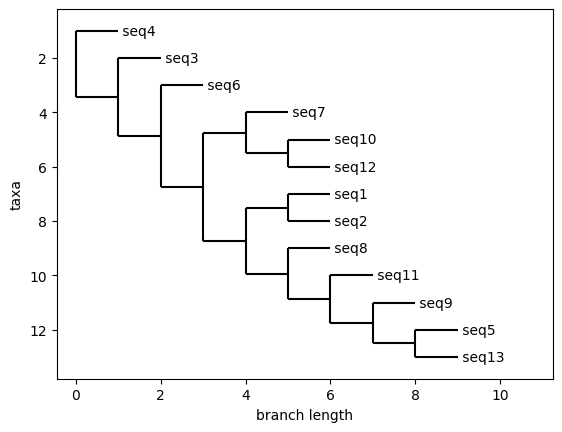

In [417]:
ma.draw_tree()

Ejemplo de como funciona con otras secuencias mas chicas

In [418]:
sqs_prot = [('NWKRKCYVWISACSYNEWIC', 'protein_1'),
            ('NWKRKCYVWISACSYNEWIC', 'protein_2'),
            ('NWKRKCYVWISACSYNEWIC', 'protein_3'),
            ('ACGYCYVWISACSYNEWIC', 'protein_4'),
            ('ACGIKCYVWISACSYNEWIC', 'protein_5')]
sqs_adn = [('TACCCTTCGCGCCTGCGTATTAGATGGCTTGCTGGAGGGGCAGGCTGAGA','seq1'),
           ('GTCGCGTTACTTTGTTTAGGGAGTTATACCATTGTTATGTTCTTAACCTT','seq2'),
           ('TACCCTTCGCGCCTGCGTATTAGATGGCTTGAGGGAGGGGCAGGCTGAGA','seq3'),
           ('GTCGCGTTACTTTGTTTAGGGAGTTATACCATTGTTATGTTCTTAACCTT','seq4'),
           ('AAATGCTTTTCGAACCGAAACGCGAAAAACATAGTATCACATTCGTCTGA','seq5')]

ma2 = MultipleAlignment(sqs_adn,"ADN")

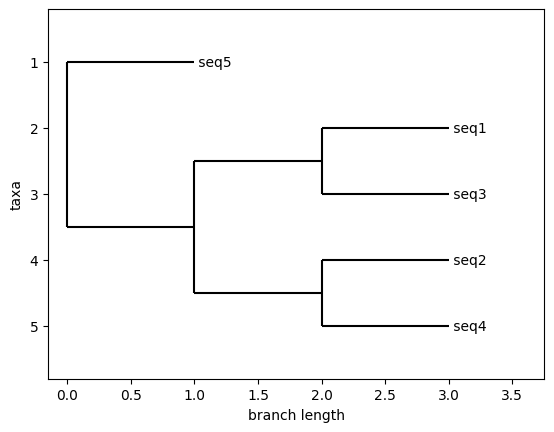

In [419]:
ma2.draw_tree()

### Comparación con alineamiento BLAST

In [420]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor

# Convertir las secuencias en objetos SeqRecord
seq_records = [SeqRecord(seq[0], id=seq[1]) for seq in sqs_adn]

# Crear un objeto MultipleSeqAlignment con las secuencias
alignment = MultipleSeqAlignment(seq_records)

# Calcular la matriz de distancias con el calculador de identidad
calculator = DistanceCalculator('identity')
distMatrix = calculator.get_distance(alignment)


/home/agustin/Escritorio/Bioinformatica/TPs/bioinformatics/lib/python3.10/site-packages/Bio/SeqRecord.py:228: BiopythonDeprecationWarning: Using a string as the sequence is deprecated and will raise a TypeError in future. It has been converted to a Seq object.
  warnings.warn(


In [421]:
print(distMatrix)

seq1    0.000000
seq2    0.800000    0.000000
seq3    0.040000    0.820000    0.000000
seq4    0.800000    0.000000    0.820000    0.000000
seq5    0.800000    0.760000    0.800000    0.760000    0.000000
    seq1    seq2    seq3    seq4    seq5


In [422]:
constructor = DistanceTreeConstructor()
UPGMATree = constructor.upgma(distMatrix)

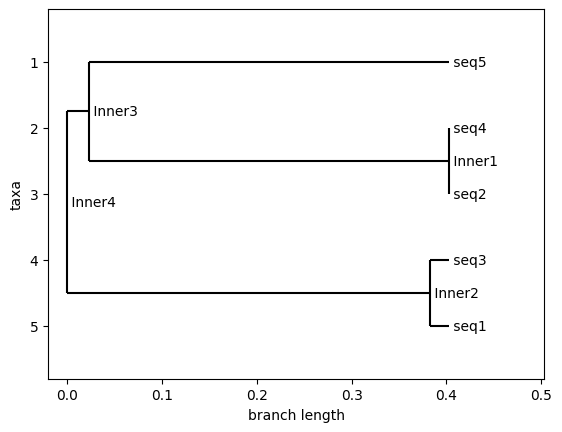

In [423]:
Phylo.draw(UPGMATree)